In [1]:
import scipy as sp
import scipy.io
import scipy.stats
import os
import numpy as np
import pandas as pd
import glob
import csv
from matplotlib import gridspec
import matplotlib.patches as patches

from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
from utils import plotting_utils as pu
from utils import utils
from utils import zscores
import itertools
import altair as alt
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)
%load_ext autoreload

In [2]:
log_df, unit_key_df = utils.load_data(os.getcwd())

In [3]:
log_df.columns

Index(['mouse_name', 'date', 'block_type', 'trial_type', 'touch_stimulus',
       'vis_stimulus', 'response', 'trial_num', 'stim_onset', 'stim_offset',
       'licks_right', 'licks_left', 'spike_times', 'cluster_name',
       'spike_times(stim_aligned)', 'first_lick', 'last_lick',
       'spike_times(lick_aligned)', 'spike_times(last_lick_aligned)',
       'identified', 'correct', 'uni_id'],
      dtype='object')

In [4]:
bin_size = 0.025
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)
unit_key_df = utils.calc_unit_stats(unit_key_df, log_df, bin_size)
log_df['spike_counts(stim_aligned)'] = log_df[
    'spike_times(stim_aligned)'].apply(lambda x: np.histogram(x,edges)[0]/bin_size)
unit_key_df = zscores.calc_z_scores(log_df, unit_key_df, bin_size, window)
opto_id = pd.read_csv('identified_units.csv')

In [5]:
log_df['baseline_spikes(-300-0ms)'] = log_df['spike_times(stim_aligned)'].apply(lambda y: sum(((y>= -.300) & (y<=0))*1)/.300)
log_df['baseline_spikes(-150-0ms)'] = log_df['spike_times(stim_aligned)'].apply(lambda y: sum(((y>= -.150) & (y<=0))*1)/.150)
log_df['stim_spikes(0-150ms)'] = log_df['spike_times(stim_aligned)'].apply(lambda y: sum(((y>= 0) & (y<=0.150))*1)/.15)
log_df['lick_spikes(-150-150ms)'] = log_df['spike_times(lick_aligned)'].apply(lambda y: sum(((y>= -.150) & (y<=0.150))*1)/.300)
log_df['lick_spikes(-150-150ms)'].head()

0    3.333333
1    3.333333
2    3.333333
3    3.333333
4    6.666667
Name: lick_spikes(-150-150ms), dtype: float64

In [6]:
opto_log = log_df.merge(opto_id, on = 'uni_id', how = 'inner')
epoch_comp = opto_log[['uni_id', 'block_type','trial_type','response', 'baseline_spikes(-300-0ms)','baseline_spikes(-150-0ms)', 'stim_spikes(0-150ms)', 'lick_spikes(-150-150ms)']]
epoch_comp.head()

,uni_id,block_type,trial_type,response,baseline_spikes(-300-0ms),baseline_spikes(-150-0ms),stim_spikes(0-150ms),lick_spikes(-150-150ms)
0,Cl405-19-178t4,Whisker,Stim_Vis_NoCue,1,0.0,0.0,0.0,0.0
1,Cl405-19-178t4,Whisker,Stim_Som_NoCue,1,0.0,0.0,0.0,0.0
2,Cl405-19-178t4,Visual,Stim_Vis_NoCue,2,0.0,0.0,0.0,0.0
3,Cl405-19-178t4,Visual,Stim_Vis_NoCue,2,0.0,0.0,0.0,0.0
4,Cl405-19-178t4,Visual,Stim_Vis_NoCue,2,0.0,0.0,0.0,0.0


In [7]:
def epoch_mean(df, output_var, condition_var = None):
    if condition_var is None:
        grouped = df.groupby([df['uni_id']])[output_var]
    else:
        grouped = df.groupby([df['uni_id'], df[condition_var]])[output_var]
    gr_mean = grouped.mean().reset_index()
    return gr_mean

In [8]:
epoch_comp.loc[(epoch_comp['uni_id'] == 'Cl506-04-176t3') &(epoch_comp['response'] == 2), 'lick_spikes(-150-150ms)'].mean()

43.2258064516129

In [9]:
gr_means_baseline = epoch_mean(epoch_comp, 'baseline_spikes(-300-0ms)', 'block_type', )

gr_means_stim = epoch_mean(epoch_comp, ['stim_spikes(0-150ms)'], 'trial_type')
gr_means_stim_baseline = epoch_mean(epoch_comp,['baseline_spikes(-150-0ms)'])
gr_means_stim_baseline['trial_type'] = 'baseline'
gr_means_stim_baseline.rename(columns = {'baseline_spikes(-150-0ms)':'stim_spikes(0-150ms)'}, inplace = True)
gr_means_stim = pd.concat([gr_means_stim, gr_means_stim_baseline], axis = 0)

gr_means_lick = epoch_mean(epoch_comp,['lick_spikes(-150-150ms)'], 'response')
gr_means_lick.loc[gr_means_lick['response'] == 0, 'response'] = 'no lick'
gr_means_lick.loc[gr_means_lick['response'] == 1, 'response'] = 'right'
gr_means_lick.loc[gr_means_lick['response'] == 2, 'response'] = 'left'

display(gr_means_baseline.head(3))
display(gr_means_stim.head(3))
display(gr_means_lick.head(3))

,uni_id,block_type,baseline_spikes(-300-0ms)
0,Cl405-19-178t4,Visual,0.437158
1,Cl405-19-178t4,Whisker,0.981735
2,Cl405-23-177t4,Visual,7.020202


,stim_spikes(0-150ms),trial_type,uni_id
0,0.367454,Stim_Som_NoCue,Cl405-19-178t4
1,0.661939,Stim_Vis_NoCue,Cl405-19-178t4
2,13.771930,Stim_Som_NoCue,Cl405-23-177t4


,uni_id,response,lick_spikes(-150-150ms)
0,Cl405-19-178t4,no lick,0.504386
1,Cl405-19-178t4,right,1.111111
2,Cl405-19-178t4,left,0.153846


In [10]:
opto_id_gen = (uni_id for uni_id in gr_means_lick['uni_id'].unique())

Cl405-19-178t4


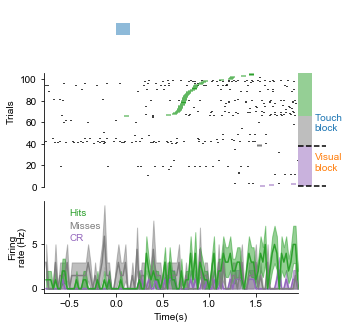

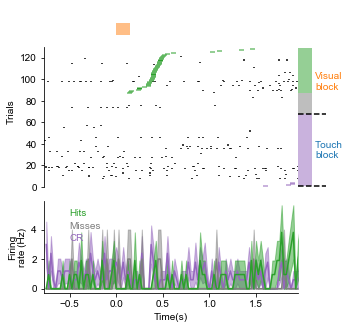

In [11]:
uni_id = next(opto_id_gen)
print(uni_id)
fig = pu.plot_unit(log_df,uni_id, -0.75,2, 0.025, size_mult = 0.7)
fig2 = pu.plot_unit(log_df,uni_id, -0.75,2, 0.025, modality = 'visual', size_mult = 0.7)


In [12]:
gr_means_baseline['label_loc'] = gr_means_baseline['baseline_spikes(-300-0ms)'].max() + 5

In [13]:
grouped_baseline = gr_means_baseline.groupby('block_type')['baseline_spikes(-300-0ms)']
grouped_stim = gr_means_stim.groupby('trial_type')['stim_spikes(0-150ms)']
grouped_lick = gr_means_lick.groupby('response')['lick_spikes(-150-150ms)']

In [14]:
list(itertools.combinations(grouped_baseline.groups.keys(),2))

[('Visual', 'Whisker')]

In [15]:
baseline_test = scipy.stats.wilcoxon(grouped_baseline.get_group('Visual'), grouped_baseline.get_group('Whisker'))

def test_groups(grouped):
    groups = list(itertools.combinations(grouped.groups.keys(),2))
    results = pd.DataFrame()
    for i,gr in enumerate(groups):
        results[i] = [gr[0], gr[1], scipy.stats.wilcoxon(grouped.get_group(gr[0]),grouped.get_group(gr[1]))]
    
    results = results.T
    results.columns = ['group1', 'group2', 'stat, pvalue']
    return results

baseline_tests = test_groups(grouped_baseline)
stim_tests = test_groups(grouped_stim)
lick_tests = test_groups(grouped_lick)

lick_tests

,group1,group2,"stat, pvalue"
0,left,no lick,"(71.0, 0.023999149663337077)"
1,left,right,"(106.0, 0.33041490332462453)"
2,no lick,right,"(48.0, 0.0035650346308531587)"


In [33]:
def linked_ladder_chart(groups):

    pts = alt.selection_single(encodings = ['color'])
    color_scale = alt.Scale(
                range=["steelblue"]
            )

    ###########################################
    ########## baseline plot ##################
    chart1 = alt.Chart(groups[0]).mark_point().encode(
        alt.X('block_type', type = 'nominal'),
        alt.Y('baseline_spikes(-300-0ms)', type= 'quantitative'),
        color = alt.condition(pts, 'uni_id', alt.value('lightgray'), scale = color_scale, legend = alt.Legend(title = ' ', values = [])),
    ).properties(
        selection=pts,
        width = 200,
        height = 300
    ).interactive()

    chart11 = alt.Chart(groups[0]).mark_line().encode(
        alt.X('block_type', type = 'nominal'),
        alt.Y('baseline_spikes(-300-0ms)', type= 'quantitative'),
        color = alt.condition(pts, 'uni_id', alt.value('lightgray'), scale = color_scale,)
    ).properties(
        width = 200,
        height = 300
    )

    text = alt.Chart(groups[0]).mark_text(align = 'left', dx = 5, dy = -.5, font='Arial').encode(
        alt.Y('label_loc', type= 'quantitative'),
        text=alt.condition(pts, 'uni_id', alt.value(' '))
    )
    ##############################################
    ######### stim plot############################
    chart2 = alt.Chart(groups[1]).mark_point().encode(
        alt.X('trial_type', type = 'nominal'),
        alt.Y('stim_spikes(0-150ms)', type= 'quantitative'),
        color = alt.condition(pts.ref(), 'uni_id', alt.value('lightgray')),
    ).properties(
        selection=pts,
        width = 200,
        height = 300
    ).interactive()

    chart21 = alt.Chart(groups[1]).mark_line().encode(
        alt.X('trial_type', type = 'nominal'),
        alt.Y('stim_spikes(0-150ms)', type= 'quantitative'),
        color = alt.condition(pts, 'uni_id', alt.value('lightgray'), scale = color_scale)
    ).properties(
        width = 200,
        height = 300
    )

    #################################################
    ######### lick plot###############################
    chart3 = alt.Chart(groups[2]).mark_point().encode(
        alt.X('response', type = 'nominal'),
        alt.Y('lick_spikes(-150-150ms)', type= 'quantitative'),
        color = alt.condition(pts.ref(), 'uni_id', alt.value('lightgray')),
    ).properties(
        selection=pts,
        width = 200,
        height = 300
    ).interactive()

    chart31 = alt.Chart(groups[2]).mark_line().encode(
        alt.X('response', type = 'nominal'),
        alt.Y('lick_spikes(-150-150ms)', type= 'quantitative'),
        color = alt.condition(pts, 'uni_id', alt.value('lightgray'), scale = color_scale)
    ).properties(
        width = 200,
        height = 300
    )

    chart = chart1+chart11+text|chart2+chart21|chart3+chart31
    
    return chart

In [51]:
gr_stim_tet6

,uni_id,response,lick_spikes(-150-150ms)
0,Cl405-31-176t1,no lick,16.011236
1,Cl405-31-176t1,right,11.481481
2,Cl405-31-176t1,left,6.935484
3,Cl406-02-176t2,no lick,17.189542
4,Cl406-02-176t2,right,19.035088
5,Cl406-02-176t2,left,19.090909
6,Cl406-03-176t1,no lick,6.352941
7,Cl406-03-176t1,right,7.927928
8,Cl406-03-176t1,left,6.666667
9,Cl506-02-176t4,no lick,5.014749


In [55]:
inds = [df['uni_id'].str.contains('6t') for df in [gr_means_baseline,gr_means_stim, gr_means_lick]]
gr_baseline_tet6 = gr_means_baseline.loc[inds[0], :].reset_index(drop = True)
gr_stim_tet6 = gr_means_stim.loc[inds[1], :].reset_index(drop = True)
gr_lick_tet6 = gr_means_lick.loc[inds[2], :].reset_index(drop = True)


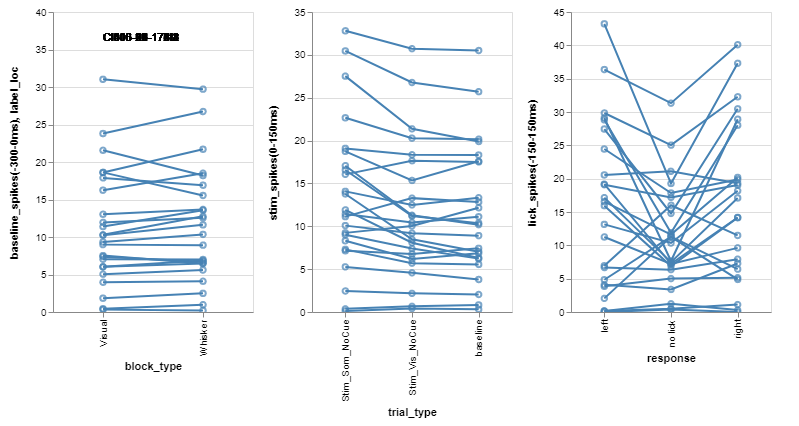

In [56]:
chart = linked_ladder_chart([gr_means_baseline, gr_means_stim, gr_means_lick])
chart2 = linked_ladder_chart([gr_baseline_tet6, gr_stim_tet6, gr_lick_tet6])

chart 

In [ ]:
chart.savechart('three_epoch.html')

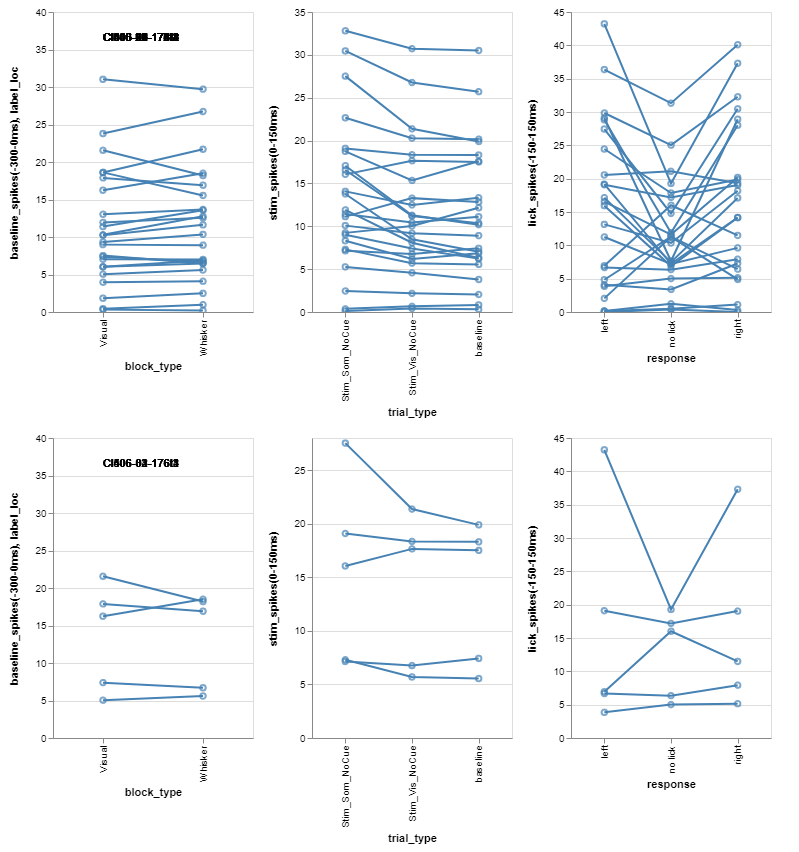

In [59]:

alt.vconcat(chart,chart2)

In [ ]:
a